In [2]:
# Load in imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import wavfile

Read in wav file and plot the audio

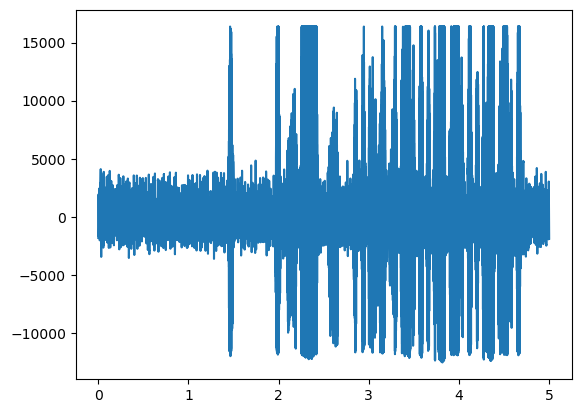

In [4]:
# Load in the wav file
fs, audio = wavfile.read('Data/2023_03_31_7_03_30.wav')
t_song = np.arange(0, len(audio)/fs, 1/fs)
 
# Display the first 10 seconds of the wav file
disp_t = 5
plt.plot(t_song[:fs*disp_t], audio[:fs*disp_t])

Use spectral entropy to find start and end times

In [3]:
from antropy import entropy

# Function for sliding window across wav file and getting spectral entropy
def get_entropy(audio, fs, window_size, window_step):
    # Get the number of windows
    n_windows = int(np.floor((len(audio) - window_size)/window_step))
    
    # Initialize the entropy array
    en = np.zeros(n_windows)

    # create time vector
    t = np.linspace(0, len(audio)/fs, n_windows)
    
    # Loop through the windows
    for i in range(n_windows):
        # Get the start and end indices of the window
        start = i*window_step
        end = start + window_size
        
        # Get the entropy of the window
        en[i] = entropy.spectral_entropy(audio[start:end], sf=fs, method='welch', normalize=True)
        
    return en, t

# Get the entropy of the wav file using a sliding window
window_size = 1323
window_step = 165
en, t = get_entropy(audio, fs, window_size, window_step)

Get syllable estimated start and end times

In [4]:
# Function to get the syllable start and end times based on crossing a threshold
def get_syllables(en, t, threshold, time_threshold=0.05):
    # Get the indices of the syllables
    syllable_indices = np.where(en > threshold)[0]

    sample_rate = 1/np.diff(t).mean()
    
    # Get the start and end times of the syllables, combining adjacent frames
    syllable_start = [t[syllable_indices[0]]]
    syllable_end = []

    for i in range(len(syllable_indices)-1):
        if syllable_indices[i+1] - syllable_indices[i] > 1:
            syllable_end.append(t[syllable_indices[i]])
            syllable_start.append(t[syllable_indices[i+1]])

    syllable_end.append(t[syllable_indices[-1]])

    syllable_start_arr = np.array(syllable_start)
    syllable_end_arr = np.array(syllable_end)
    duration = syllable_end_arr-syllable_start_arr

    return syllable_start_arr[duration > time_threshold], syllable_end_arr[duration > time_threshold]

# Get the syllable start and end times
syllable_start, syllable_end = get_syllables(en, t, 0.4)

(0.0, 5.0)

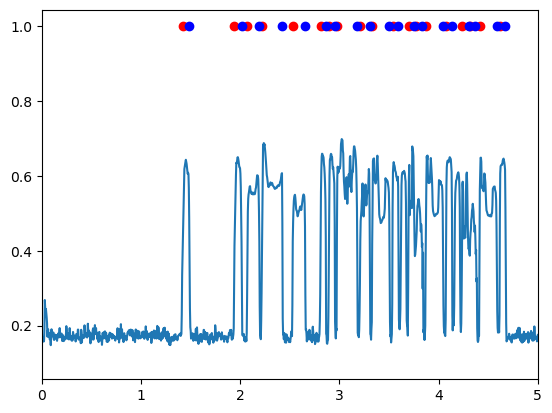

In [5]:
# Plot the start and end times on top of the entropy
plt.plot(t, en)
plt.plot(syllable_start, np.ones(len(syllable_start)), 'ro')
plt.plot(syllable_end, np.ones(len(syllable_end)), 'bo')
plt.xlim([0, 5])

Create syllable dataframe

In [6]:
# Make a dataframe of the syllable audio and start and end times
syllables = pd.DataFrame(columns=['start', 'end', 'audio', 'spec_entropy'])

for i in range(len(syllable_start)):
    start_s = syllable_start[i] # returns time in seconds
    start = np.searchsorted(t_song, start_s)

    end_s = syllable_end[i] # returns time in seconds
    end = np.searchsorted(t_song, end_s)

    audio_syl = audio[start:end]
    spec_entropy = entropy.spectral_entropy(audio[start:end], sf=fs, method='welch', normalize=True)

    syllables.loc[i] = [start_s, end_s, audio_syl, spec_entropy]

# make all syllables the same length
max_length = syllables['audio'].apply(len).max()
syllables['audio'] = syllables['audio'].apply(lambda x: np.pad(x, (0, max_length-len(x)), 'constant'))

(array([ 10.,  29.,  92., 249., 412., 505., 411., 342., 173.,  34.]),
 array([0.41002266, 0.43973311, 0.46944357, 0.49915402, 0.52886448,
        0.55857493, 0.58828538, 0.61799584, 0.64770629, 0.67741674,
        0.7071272 ]),
 <BarContainer object of 10 artists>)

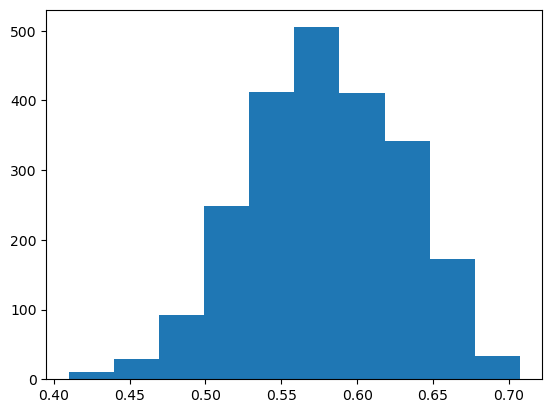

In [7]:
# Plot histogram of entropy
plt.hist(syllables['spec_entropy'])

c:\Users\nriveira\AppData\Local\anaconda3\envs\antropy\Lib\site-packages\matplotlib\axes\_axes.py:7939: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


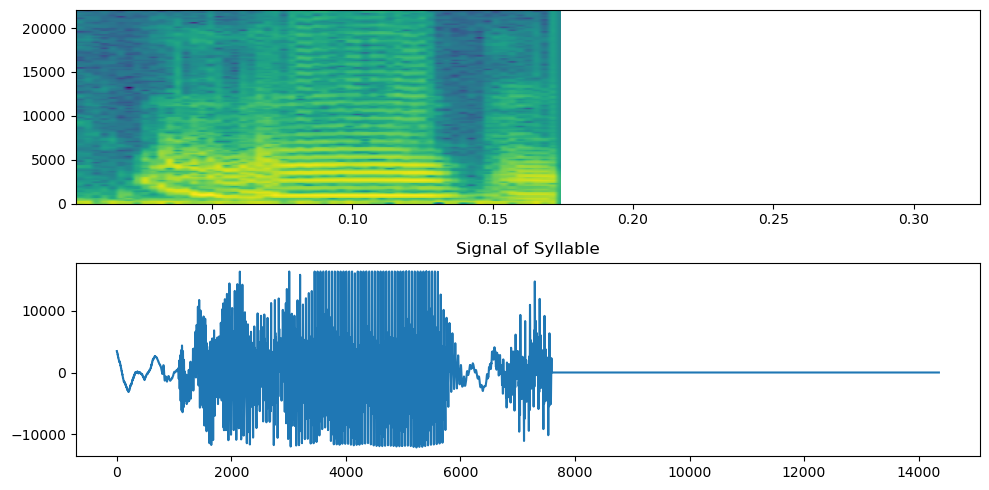

In [8]:
# Play first syllable
from IPython.display import Audio
syll = 9

# Plot spectrogram (in dB) and signal of first syllable
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.specgram(syllables.audio[syll], Fs=fs)
plt.subplot(212)
plt.plot(syllables.audio[syll])
plt.title('Signal of Syllable')
plt.tight_layout()

Audio(syllables.audio[syll], rate=fs)

Save pandas structure to use librosa features in another environment

In [9]:
syllables.to_pickle('syllables.pkl')
syllables.head()

,start,end,audio,spec_entropy
0,1.421780,1.485386,"[-455, -495, -523, -505, -456, -436, -438, -45...",0.638779
1,1.941853,2.012942,"[-985, -987, -967, -935, -905, -901, -865, -81...",0.648404
2,2.072806,2.192535,"[-505, -489, -493, -560, -606, -652, -700, -73...",0.587794
3,2.222467,2.424510,"[-1128, -1128, -1117, -1154, -1191, -1201, -11...",0.612076
4,2.529272,2.652743,"[1969, 2001, 2000, 1971, 1979, 1975, 1958, 195...",0.536506
